Fallstudie:<br> 
**Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe**

# Import & Helpers

In [1]:
#! mlflow server --host 127.0.0.1 --port 8080

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 100)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import datetime as dt
import numpy as np
import re

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style='darkgrid',)
color_pal = sns.color_palette("muted")
sns.set_palette(color_pal)
sns.set_context("paper")
%matplotlib inline
# plot dimensions
plot_width = 12
plot_height = 8
palette_success ={0: color_pal[1], 1: color_pal[2]}

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

import mlflow
from mlflow.models import infer_signature

In [3]:
# parameter
rs = 23 # random state

# MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# date of today as string
dt_today = str(dt.date.today())

In [4]:
def track_model(training_info, model, x_test, y_test, y_pred, y_pred_auc, feature_names):
    # Set a tag as detailed description of run
    mlflow.set_tag("Training Info", training_info)
    
    # Log the hyperparameters
    mlflow.log_params(model.get_params())
    
    # Log the metrics
    mlflow.log_metrics({"AUC": roc_auc_score(y_test, y_pred_auc), 
                       "Precision": precision_score(y_test, y_pred, zero_division=np.nan), 
                       "Recall": recall_score(y_test, y_pred, zero_division=np.nan), 
                       "F1-score": f1_score(y_test, y_pred, zero_division=np.nan)})
     
    # check options to find out model-specific FEATURE IMPORTANCES
    plot_title = "No information on feature importances"
    if (hasattr(model, "feature_importances_") == True):
        feat_imp = model.feature_importances_
        plot_title = "Feature importances"
    elif (hasattr(model, "coef_") == True):
        feat_imp = model.coef_[0]
        plot_title = "Coefficients"
    else:
        feat_imp = len(feature_names) * [0]
        print("Has NO feature importances")
    
    # save feature importance to DF
    df_feat_imp = (pd.DataFrame(list(zip(feature_names, feat_imp)), 
                             columns=["Feature", "Model_specific_imp"])
                .set_index("Feature"))
    
    # PERMUTATION FEATURE IMPORTANCE (PFI) 
    pfi_result = permutation_importance(estimator=model, X=x_test, y=y_test, scoring="roc_auc", random_state=rs, n_repeats=10)
    df_pfi = (pd.DataFrame(list(zip(feature_names, pfi_result.importances_mean)), 
                           columns=["Feature", "PFI"])
              .set_index("Feature"))
    # join both dataframes
    df_feat_imp = df_feat_imp.join(df_pfi, how="left").sort_values("PFI", ascending=False).reset_index()
    
    csv_path = "artifacts/feature_importance.csv"
    df_feat_imp.to_csv(csv_path, index=True)
    mlflow.log_artifact(csv_path, "feature_importance.csv")
    
    # Log plot of feature importance
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    sns.barplot(y="Feature", x="Model_specific_imp", data=df_feat_imp, ax=ax[0])
    ax[0].set_title("Model-specific feature importances", fontsize=10)
    sns.barplot(y="Feature", x="PFI", data=df_feat_imp, ax=ax[1])
    ax[1].set_title("Permutation feature importances", fontsize=10)
    #plt.title(plot_title)
    #plt.xlabel("Importance")
    #plt.ylabel("Feature")
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1, wspace=0.6)
    mlflow.log_figure(fig, "feature_importance.png")
    
    
    # Infer the model signature
    #signature = infer_signature(x_train, y_train)
    # Log the model
    """model_info = mlflow.sklearn.log_model(sk_model=model, 
                                          artifact_path="baseline_model", 
                                          signature=signature, 
                                          input_example=x_train.head(5))"""

# Data preparation 2

In [5]:
df_trx = (pd.read_excel("../data/03_interim/df_trx_training.xlsx", sheet_name="df_trx")
          .drop(columns=["Unnamed: 0"])
          .rename(columns={"x_tmsp":"meta_tmsp"}))

In [6]:
# raw x- and y-variables
x_ = [x for x in list(df_trx.columns) if re.match("^x_", x)!=None]
y_ = [y for y in list(df_trx.columns) if re.match("^y_", y)!=None]
meta_ = [m for m in list(df_trx.columns) if m.find("meta_")!=-1]

In [7]:
df_trx[x_].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37612 entries, 0 to 37611
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   x_country                  37612 non-null  object 
 1   x_amount                   37612 non-null  int64  
 2   x_psp                      37612 non-null  object 
 3   x_3d_secured               37612 non-null  int64  
 4   x_card                     37612 non-null  object 
 5   x_tmsp_wd_str              37612 non-null  object 
 6   x_tmsp_daytime             37612 non-null  object 
 7   x_tmsp_h_sin               37612 non-null  float64
 8   x_tmsp_h_cos               37612 non-null  float64
 9   x_tmsp_wd_sin              37612 non-null  float64
 10  x_tmsp_wd_cos              37612 non-null  float64
 11  x_enc_country_Austria      37612 non-null  bool   
 12  x_enc_country_Germany      37612 non-null  bool   
 13  x_enc_country_Switzerland  37612 non-null  boo

Je nach Modell gibt es 2 Features-Sets:<br>

Für Modelle, die numerische Features benötigen: 
- 16 Features
- davon 6 numerische Features, die skaliert werden müssen
- und 10 Features vom Typ Boolean, die aus dem One Hot Encoding entstanden sind und als Integer encoded werden<br>

Für Modelle, bei denen der Typ der Features egal ist:
- 11 Features
- davon 6 numerische Features
- und 5 categorial Features vom Typ Object

In [8]:
# categorize features
feat_object_native = list(df_trx[x_].select_dtypes(include="object").columns) # original features of type object
#feat_object_bool_enc = list(df_trx[x_].select_dtypes(include="bool").columns) # encoded object features as bool
feat_num = list(df_trx[x_].select_dtypes(include="number").columns) # numerical features for scaling

## Train-Test-Split

In [9]:
# shuffle and stratify
x_train, x_test, y_train, y_test = train_test_split(df_trx[x_], df_trx[y_], test_size=0.2, random_state=rs, shuffle=True, stratify=df_trx[y_])
y_train= y_train.iloc[:, 0]
y_test= y_test.iloc[:, 0]

In [10]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
print(f"Trainings data set consists of {train_size} records, while the test data set consists of {test_size} records.")

Trainings data set consists of 30089 records, while the test data set consists of 7523 records.


## Feature Engineering Pipeline

In [11]:
# column transformer for models requiring numerical, scaled input features
coltransformer_4numerical = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include="number")), 
    (OrdinalEncoder(), make_column_selector(dtype_include="bool"))
)

## Features

In [12]:
# for model with numerical input
coltransformer_4numerical.fit(x_train)
x_train_numerical = coltransformer_4numerical.transform(x_train)
x_test_numerical = coltransformer_4numerical.transform(x_test)

In [13]:
# for model with raw input
x_train_raw = x_train[feat_num + feat_object_native]
x_test_raw = x_test[feat_num + feat_object_native]

# Modeling no. 1 

## Test design
Ziele:
- erfolgreiche Transaktionen in Abhängigkeit vom PSP (und den anderen Umständen) erkennen
- positiv = success
- wir müssen dem Kunden einen PSP zuordnen und wollen daher den PSP wählen, der die höchste Erfolgswahrscheinlichkeit hat
- keine PSP zu wählen ist keine Option
  
Vergleich der Modelle:
- Wir sind nicht nur an der Klassifikation an sich interessiert, sondern v.a. auch an der Wahrscheinlichkeit für einen Erfolg abhängig von dem PSP. Der Predictor muss keine fixe Vorhersage über Erfolg/Misserfolg treffen, sondern in Abhängigkeit vom PSP die Erfolgswahrscheinlichkeit berechnen (es wird kein Threshold festgelegt).
- AUC ist eine Vergleichsmetrik, die unabhängig vom gewählten Threshold ist.

Weitere Metriken zur Bewertung der Performance, aber nicht entscheidend:
- Precision meiner Vorhersage: keine Falschpositiven, um mehrfache Transaktionsgebühren zu sparen
- Recall/TPR/Sensitivity: möglichst viele erfolgreiche Transaktionen vorhersagen, um eine Auswahl an PSPs zu haben, um die Kosten minimieren zu können
- F1-Score als harmonisches Mittel

## Baseline model
2 Strategien kommen in Frage:
- most_frequent: macht wenig Sinn, weil dann kein Erfolg vorhergesagt wird, so dass Precision nicht berechnet werden kann. Recall/Sensitity ist ebenfalls = 0
- stratified: It generates predictions by respecting the class distribution of the training data. It is different from the “most frequent” strategy as it instead associates a probability with each data point of being the most frequent class label.

In [14]:
# Training and prediction
baseline_clf = DummyClassifier(strategy="stratified", random_state=rs)
baseline_clf.fit(x_train_raw, y_train)

y_pred_baseline = baseline_clf.predict(x_test_raw)
y_pred_baseline_prob = baseline_clf.predict_proba(x_test_raw)
auc = roc_auc_score(y_test, y_pred_baseline_prob[:, 1], average="macro")
prec = precision_score(y_test, y_pred_baseline, zero_division=np.nan)
recall = recall_score(y_test, y_pred_baseline, zero_division=np.nan)
f1 = f1_score(y_test, y_pred_baseline, zero_division=np.nan)

print(f"Baseline-model")
print(f"with AUC: {auc:.2f}")
print(f"with precision: {prec:.2f}")
print(f"with recall: {recall:.2f}")
print(f"and F1-score: {f1:.2f}")

Baseline-model
with AUC: 0.50
with precision: 0.21
with recall: 0.21
and F1-score: 0.21


## 1st training of models (w/o class_weights)

In [15]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

In [16]:
# collect all models
# names
first_step_clf_names = ["Baseline model stratified", 
                        "Logistic Regression", 
                        "Naive Bayes", 
                        "KNN", 
                        "Decision Tree", 
                        "Linear SVM"  
                        "SVC", 
                        "LDA", 
                        "QDA",
                        "Random Forest", 
                        "Gradient Boosting", 
                        "Extra Trees"]

# configure random see
params_rs = {"random_state": rs}

# sklearn models
first_step_clf = [DummyClassifier(strategy="stratified", **params_rs), 
                  LogisticRegression(penalty=None, **params_rs), 
                  CategoricalNB(), 
                  KNeighborsClassifier(), 
                  DecisionTreeClassifier(**params_rs),
                  LinearSVC(**params_rs)
                  SVC(probability=True, **params_rs), 
                  LinearDiscriminantAnalysis(), 
                  QuadraticDiscriminantAnalysis(),
                  RandomForestClassifier(**params_rs), 
                  GradientBoostingClassifier(**params_rs), 
                  ExtraTreesClassifier(**params_rs)]

# feature mode for model
first_step_feat_mode = ["raw", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric"]

first_step_zip = zip(first_step_clf_names, first_step_clf, first_step_feat_mode)

'# collect all models\n# names\nfirst_step_clf_names = ["Baseline model stratified", \n                        "Logistic Regression", \n                        "Naive Bayes", \n                        "KNN", \n                        "Decision Tree", \n                        "Linear SVM"  \n                        "SVC", \n                        "LDA", \n                        "QDA",\n                        "Random Forest", \n                        "Gradient Boosting", \n                        "Extra Trees"]\n\n# configure random see\nparams_rs = {"random_state": rs}\n\n# sklearn models\nfirst_step_clf = [DummyClassifier(strategy="stratified", **params_rs), \n                  LogisticRegression(penalty=None, **params_rs), \n                  CategoricalNB(), \n                  KNeighborsClassifier(), \n                  DecisionTreeClassifier(**params_rs),\n                  LinearSVC(**params_rs)\n                  SVC(probability=True, **params_rs), \n                  Linear

Training and logging of model Baseline model stratified as classifier DummyClassifier(random_state=23, strategy='stratified') with feature mode raw
Has NO feature importances
For Baseline model stratified: Run logged in MLflow with ea463ddb3ba44b19bd0cb0bcbba50e8a.
---------------------- 

Training and logging of model Logistic Regression as classifier LogisticRegression(penalty=None, random_state=23) with feature mode numeric
For Logistic Regression: Run logged in MLflow with d06e577548154b1bb5a44c7c80b9226a.
---------------------- 

Training and logging of model Naive Bayes as classifier CategoricalNB() with feature mode numeric
Has NO feature importances
For Naive Bayes: Run logged in MLflow with 0f6d767a5cba4331aec116c9f5aab12d.
---------------------- 



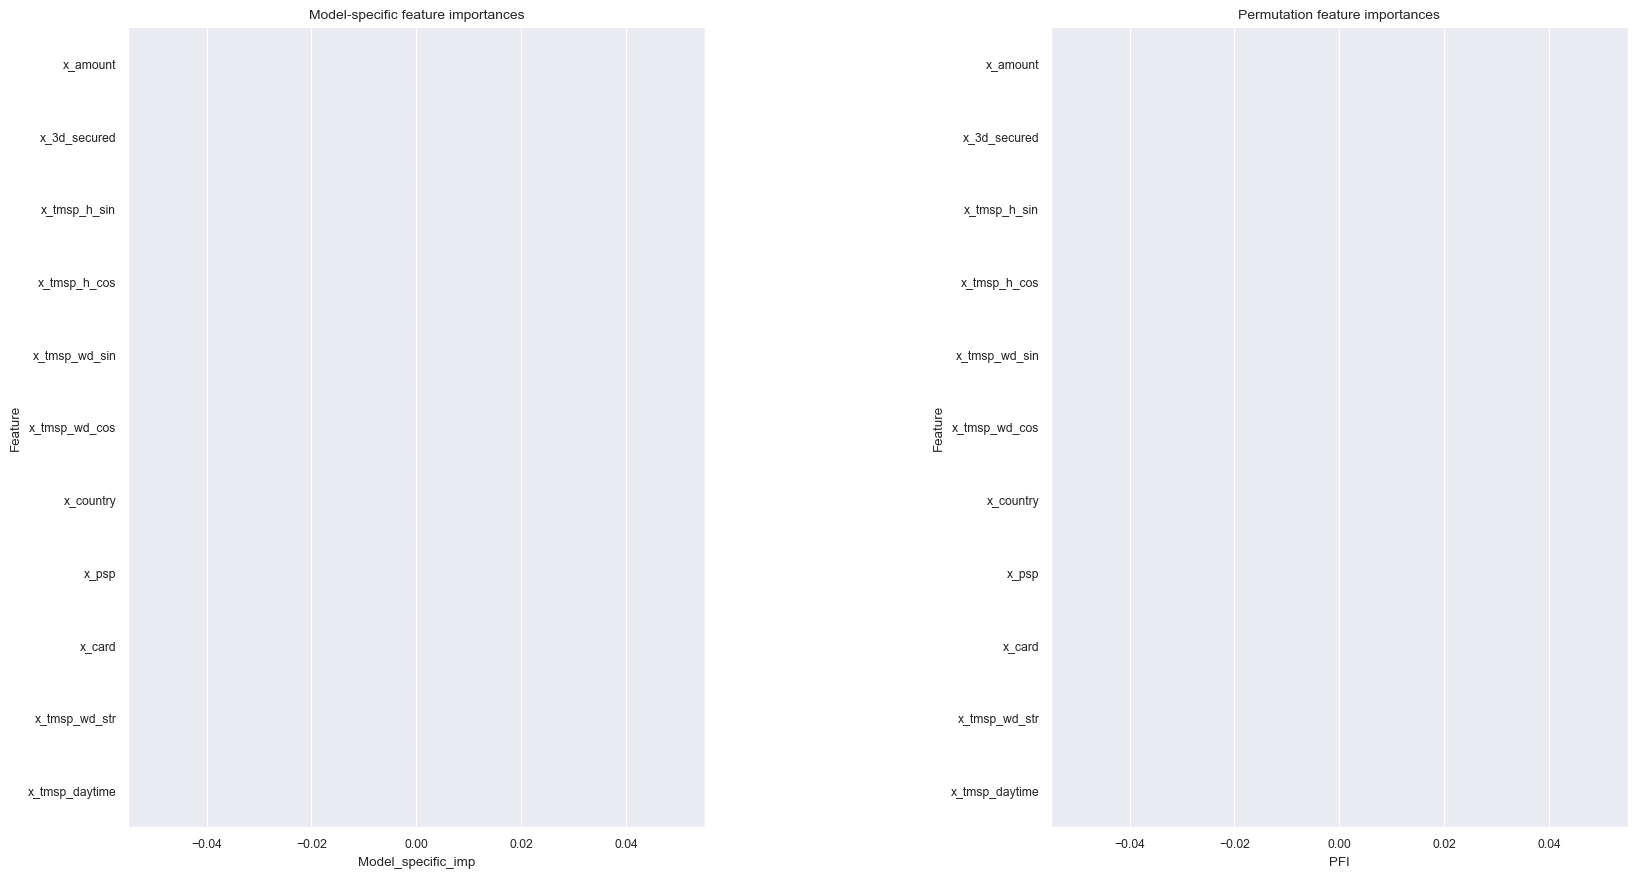

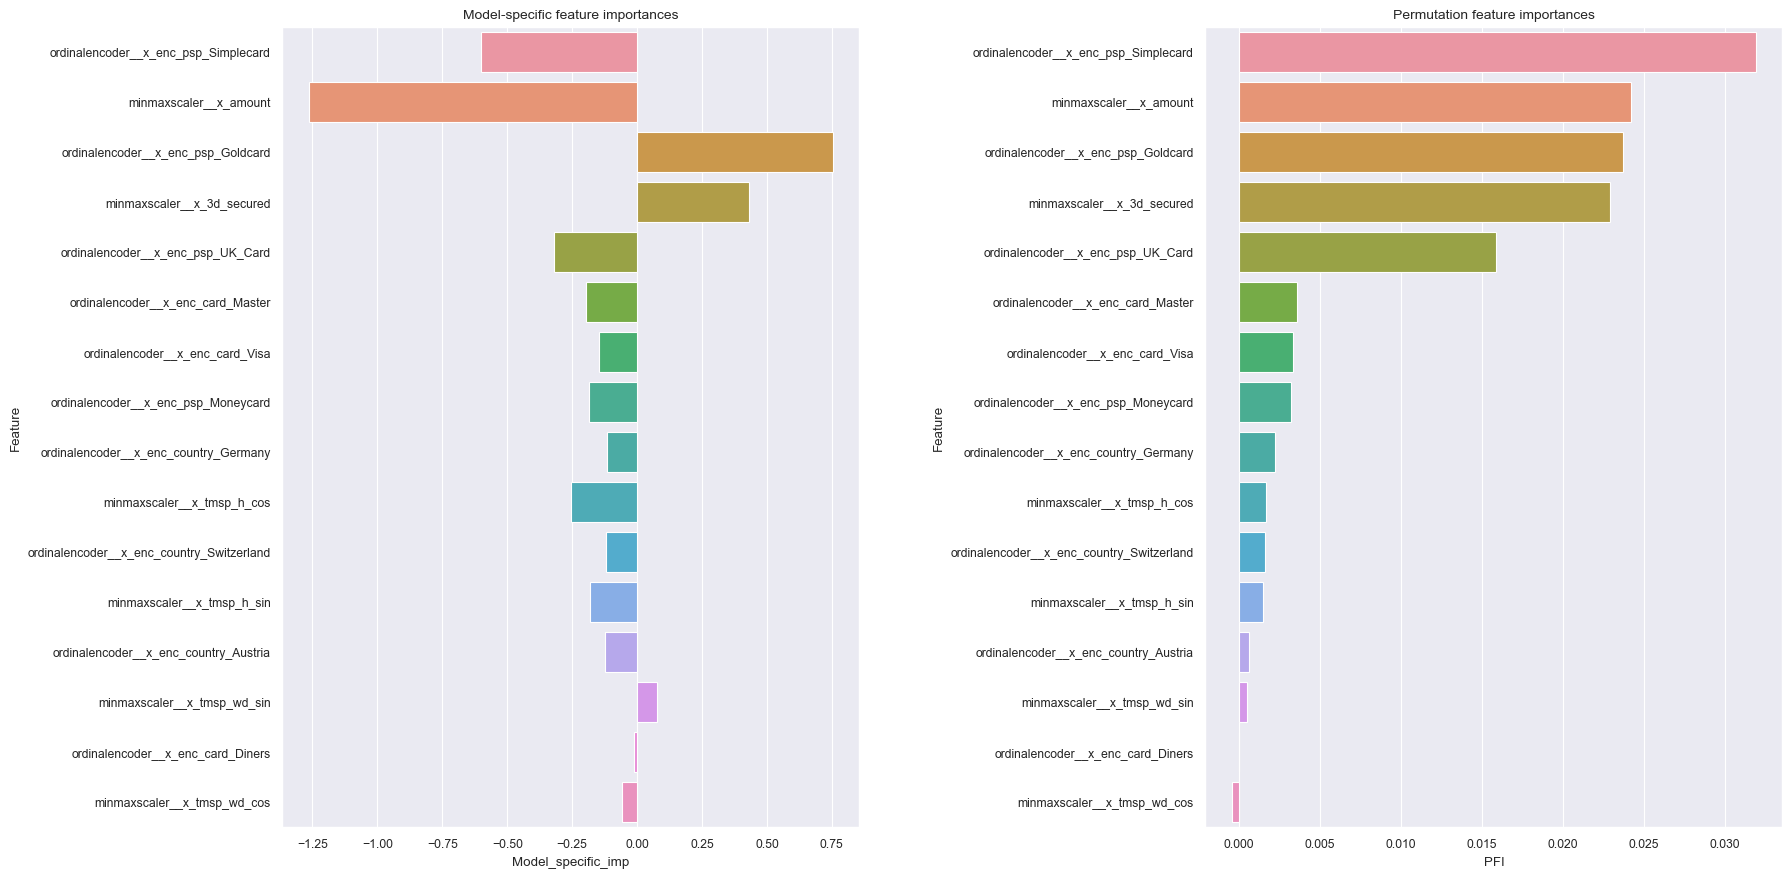

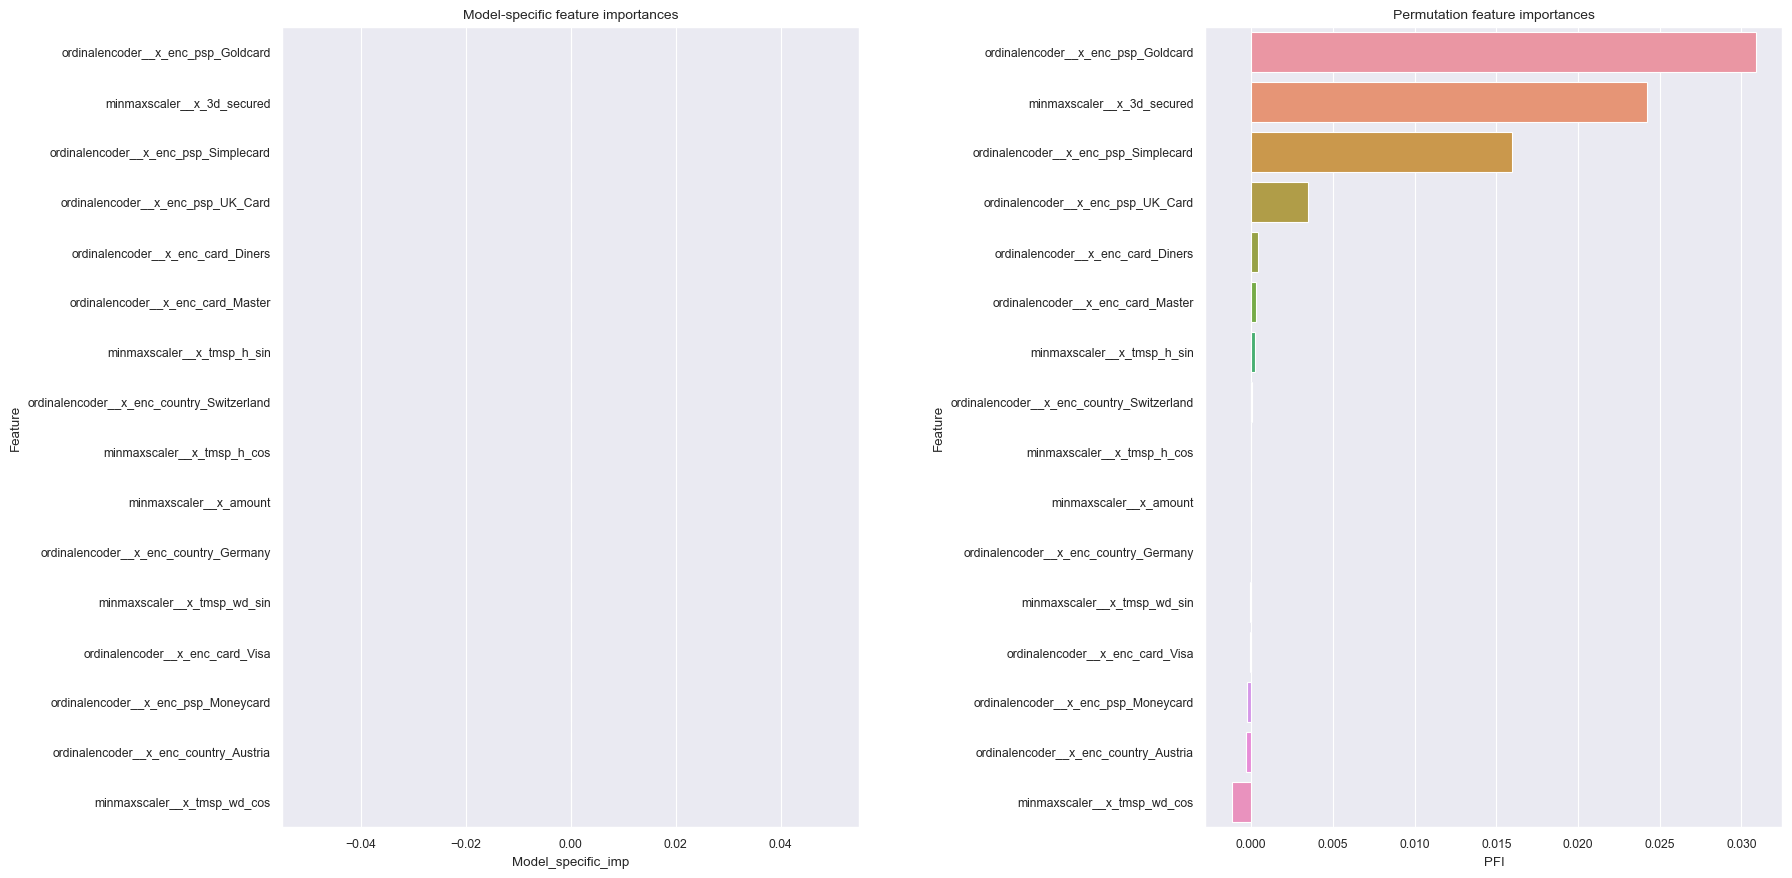

In [18]:
first_exp = "PSP_1_w/o_class_weights"
first_info = "1. Training for comparison of models WITHOUT hyperparameter tuning"
for n, c, fm in first_step_zip:
    print(f"Training and logging of model {n} as classifier {c} with feature mode {fm}")
    if fm == "raw":
        x_train = x_train_raw
        x_test = x_test_raw
        feature_names = list(x_train_raw.columns)
    else:
        x_train = x_train_numerical
        x_test = x_test_numerical
        feature_names = list(coltransformer_4numerical.get_feature_names_out())
        
    # Create a new MLflow Experiment
    mlflow.set_experiment(first_exp)
    
    # Start an MLflow run
    run_name = dt_today + "_" + n
    with mlflow.start_run(run_name=run_name) as run:
        training_info = n + " - " + first_info
        # Training and prediction
        model = c
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        if (hasattr(model, "decision_function") == True):
            y_pred_auc = model.decision_function(x_test)
        else:
            y_pred_auc = model.predict_proba(x_test)[:, 1]

        track_model(training_info, model, x_test, y_test, y_pred, y_pred_auc, feature_names)

        run_id = run.info.run_id
    
    print(f"For {n}: Run logged in MLflow with {run_id}.")
    print("---------------------- \n")

## Evaluate & understand 1st model training
https://christophm.github.io/interpretable-ml-book/feature-importance.html
https://scikit-learn.org/stable/modules/permutation_importance.html

# Modeling no. 2

## Random search for hyperparameter tuning

In [ ]:
# collect all models
# names
hp_clf_names = ["Logistic Regression",  
                "KNN", 
                "Decision Tree", 
                "Linear SVM", 
                "SVC",
                "Random Forest", 
                "Gradient Boosting", 
                "Extra Trees"]

# configure parameters per model
hp_baseline = {"strategy": ["most_frequent", "stratified"]}
hp_lr = {"penalty": ["l1", "l2", "elasticnet", None], 
         "C": np.arange(0.01, 10, 0.1), 
         "l1_ratio": np.arange(0.1, 1.01, 0.1)}
hp_nb = {"alpha": np.arange(0, 10, 0.1)}
hp_knn = {"n_neighbors": np.arange(5, 52, 2), 
          "weights": ["uniform", "distance"], 
          "algorithm": ["ball_tree", "kd_tree", "brute"], 
          "p": np.arange(1, 2.1, 0.1)}
hp_dt = {"criterion": ["gini", "entropy", "log_loss"], 
         "splitter": ["best", "random"], 
         "max_depth": np.arange(2, 52, 2), 
         "min_samples_split": np.arange(2, 52, 2), 
         "min_samples_leaf": np.arange(1, 32, 2)}
hp_lin_svm = {"penalty": ["l1", "l2"], 
              "C": np.arange(0, 10, 0.1)}
hp_svc = {"C": np.arange(0, 10, 0.1), 
          "kernel": ["linear", "poly", "rbf", "sigmoid"], 
          "degree":[2, 3, 4, 5], 
          "gamma":["scale", "auto"]}
hp_rf = {"n_estimators": np.arange(10, 300, 20), "criterion": ["gini", "entropy", "log_loss"], 
         "max_depth": np.arange(2, 50, 2), 
         "min_samples_split": np.arange(2, 50, 2), 
         "min_samples_leaf": np.arange(1, 30, 2), 
         "max_features": [None, "sqrt", "log2"]}
hp_grad_boost = {"loss": ["log_loss", "exponential"], 
                 "learning_rate":np.arange(0.1, 1.5, 0.1), 
                 "subsample": np.arange(0.3, 0.99, 0.1), 
                 "criterion": ["friedman_mse", "squared_error"], 
                 "min_samples_split": np.arange(2, 50, 2), 
                 "min_samples_leaf": np.arange(1, 30, 2), 
                 "max_depth": np.arange(2, 50, 2), 
                 "max_features": [None, "sqrt", "log2"]}
hp_extra = {"criterion": ["gini", "entropy", "log_loss"], 
            "max_depth": np.arange(2, 52, 2), 
            "min_samples_split": np.arange(2, 52, 2), 
            "min_samples_leaf": np.arange(1, 32, 2), 
            "max_features": [None, "sqrt", "log2"], 
            "min_weight_fraction_leaf": np.arange(0, 0.5, 0.1)}

# parameters collected
hp_params = [hp_lr, hp_knn, hp_dt, hp_lin_svm, hp_svc, hp_rf, hp_grad_boost, hp_extra]

# sklearn models
hp_clf = [LogisticRegression(solver="saga", random_state=rs), 
          KNeighborsClassifier(), 
          DecisionTreeClassifier(random_state=rs), 
          LinearSVC(dual="auto", random_state=rs), 
          SVC(probability=True, random_state=rs),
          RandomForestClassifier(random_state=rs), 
          GradientBoostingClassifier(random_state=rs), 
          ExtraTreesClassifier(random_state=rs)]

# feature mode for model
hp_feat_mode = ["numeric", 
                "numeric", 
                "numeric", 
                "numeric", 
                "numeric", 
                "numeric", 
                "numeric", 
                "numeric"]

hp_zip = zip(hp_clf_names, hp_clf, hp_params, hp_feat_mode)

In [ ]:
# Config RandomizedSearchCV
scorer_auc = make_scorer(roc_auc_score)
scorer_precision = make_scorer(precision_score)
scorer_recall = make_scorer(recall_score)
scorer_f1 = make_scorer(f1_score)

randomized_scoring = {"auc": scorer_auc, 
                        "precision": scorer_precision, 
                        "recall": scorer_recall, 
                        "F1": scorer_f1}
randomized_iter = 30
randomized_cv = 5

In [ ]:
"""experiment = "PSP_1_w/o_class_weights"
info = "Training incl hyperparameter tuning"

for n, c, p, fm in hp_zip:
    print(f"RandomSearchCV and logging of model {n} as classifier {c} with feature mode {fm}")
    if fm == "raw":
        x_train = x_train_raw
        x_test = x_test_raw
        feature_names = list(x_train_raw.columns)
    else:
        x_train = x_train_numerical
        x_test = x_test_numerical
        feature_names = list(coltransformer_4numerical.get_feature_names_out())
        
    # Create a new MLflow Experiment
    mlflow.set_experiment(experiment)
    
    # Start an MLflow run
    run_name = dt_today + "_" + n + "_BestPredictor"
    with mlflow.start_run(run_name=run_name) as run:
        training_info = n + " - " + info

        random_search = RandomizedSearchCV(c, 
                                           param_distributions=p, 
                                           n_iter=randomized_iter, 
                                           verbose=2, 
                                           cv=randomized_cv, 
                                           scoring=randomized_scoring, 
                                           refit="auc", 
                                           random_state=rs, 
                                           error_score="raise")
        # Training and prediction
        random_search.fit(x_train, y_train)
        model_best = random_search.best_estimator_
        y_pred = model_best.predict(x_test)

        track_model(training_info, model_best, y_test, y_pred, feature_names)

        run_id = run.info.run_id
    
    print(f"For {n}: Run logged in MLflow with {run_id}.")
    print("---------------------- \n")"""